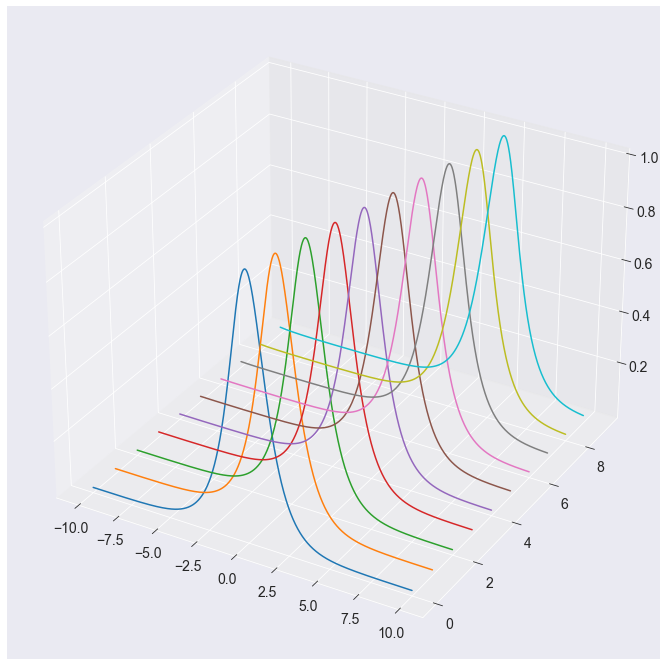

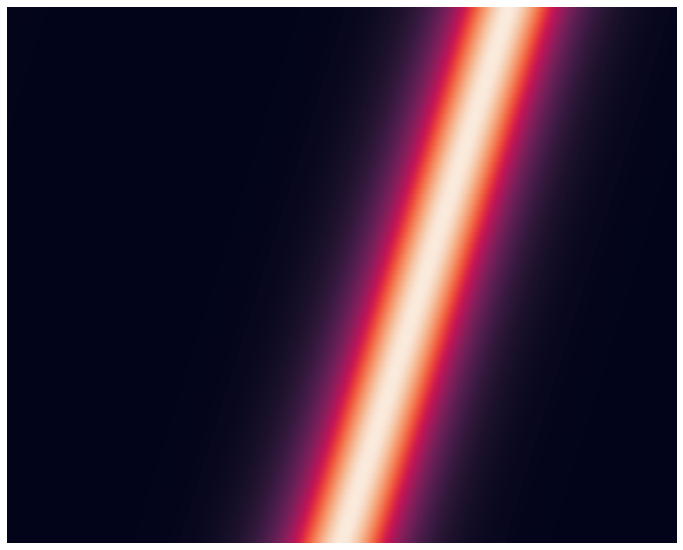

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams.update({'font.size': 14})

c = 2  # Wave speed
L = 20  # Length of domain
N = 1000  # Number of discretization points
dx = L / N
x = np.arange(-L / 2, L / 2, dx)  # Define x domain

# Define discrete wavenumbers
kappa = 2 * np.pi * np.fft.fftfreq(N, d=dx)

# Initial condition
u0 = 1 / np.cosh(x)
u0hat = np.fft.fft(u0)

# SciPy's odeint function doesn't play well with complex numbers, so we recast 
# the state u0hat from an N-element complex vector to a 2N-element real vector
u0hat_ri = np.concatenate((u0hat.real, u0hat.imag))

# Simulate in Fourier frequency domain
dt = 0.025
t = np.arange(0, 100 * dt, dt)


def rhsWave(uhat_ri, t, kappa, c):
    uhat = uhat_ri[:N] + (1j) * uhat_ri[N:]
    d_uhat = -c * (1j) * kappa * uhat
    d_uhat_ri = np.concatenate((d_uhat.real, d_uhat.imag)).astype('float64')
    return d_uhat_ri


uhat_ri = odeint(rhsWave, u0hat_ri, t, args=(kappa, c))
uhat = uhat_ri[:, :N] + (1j) * uhat_ri[:, N:]


# Alternatively, simulate in spatial domain
def rhsWaveSpatial(u, t, kappa, c):
    uhat = np.fft.fft(u)
    d_uhat = (1j) * kappa * uhat
    d_u = np.fft.ifft(d_uhat).real
    du_dt = -c * d_u
    return du_dt


u = odeint(rhsWaveSpatial, u0, t, args=(kappa, c))

# Inverse FFT to bring back to spatial domain
u = np.zeros_like(uhat)

for k in range(len(t)):
    u[k, :] = np.fft.ifft(uhat[k, :])

u = u.real

# Waterfall plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

u_plot = u[0:-1:10, :]
for j in range(u_plot.shape[0]):
    ys = j * np.ones(u_plot.shape[1])
    ax.plot(x, ys, u_plot[j, :])

# Image plot
plt.figure()
plt.imshow(np.flipud(u), aspect=8)
plt.axis('off')
plt.show()